# Dataset Creation

**Aim**: Create a dataset for future analysis.

**Necessary Downloads**: Befosre starting be sure to have downloaded the following material.

1) Download the entire MSigDB for **Human** in **JSON** format (`Human Gene Set JSON file set (ZIPped)`): [link](https://www.gsea-msigdb.org/gsea/downloads.jsp)

2) Dowload UniRef50
    - from website [link](https://www.uniprot.org/uniref?query=%28identity%3A0.5%29+AND+%28taxonomy_id%3A9606%29)
    - programmatically: using terminal 
        - **ATTENTION** with this call we retrive all cluster with at least 1 human protein, not just the human porteins
```bash
curl -o uniref50_human.tsv.gz "https://rest.uniprot.org/uniref/stream?compressed=true&fields=id,name,organism,length,identity,count,members&format=tsv&query=((identity:0.5)+AND+(taxonomy_id:9606))"
gunzip uniref50_human.tsv.gz
```

- Download full XML Uniref50 (unfortunalty FASTA version or already filtered form website do nto return all protein lsist)
```bash
wget ftp://ftp.uniprot.org/pub/databases/uniprot/uniref/uniref50/uniref50.xml.gz
gunzip uniref50.xml.gz  # The .gz file is deleted automatically, so you don’t double the disk usage.
```
- Install xmlstarlet to manilplate xml
```bash
sudo apt install xmlstarlet
```
- Reduce to only human rpoteins
```bash
xmlstarlet ed \
  -d '//entry[not(representativeMember/dbReference/property[@type="organism" and @value="Homo sapiens"] | member/dbReference/property[@type="organism" and @value="Homo sapiens"])]' \
  -d '//member[not(dbReference/property[@type="organism" and @value="Homo sapiens"])]' \
  -d '//representativeMember[not(dbReference/property[@type="organism" and @value="Homo sapiens"])]' \
  uniref50.xml > uniref50_human.xml
```


3) Download list of all HUMAN proteins
    - from Uniprt webite [link](https://www.uniprot.org/proteomes/UP000005640)
    - programmatically: using terminal 
```bash
wget -O human_proteome.tsv.gz "https://rest.uniprot.org/uniprotkb/stream?compressed=true&fields=accession,reviewed,id,protein_name,gene_names,organism_name,sequence&format=tsv&query=(proteome:UP000005640)"
gunzip human_proteome.tsv.gz
```

## Hyperparameters

In [4]:
import json
import os
import re
import pandas as pd

import utils.dataset_functions as dataf

# Directory containing MSigDB JSON files
JSON_DIR = "/home/gdallagl/myworkdir/data/MSigDB/msigdb_v2025.1.Hs_json_files_to_download_locally"

# Garated genes list
GUARANTEED_GENES_PATH = "/home/gdallagl/myworkdir/data/MSigDB/julies_cycling_signatures_cancer.tsv"

# Updated keywords pattern with word boundaries to avoid false matches
KEYWORDS_PATTERN = r"(?:PROLIFERA|\bPROLIFER\b|_PROLIFER_|_CYCLING_|^CELL_CYCLE_|_CELL_CYCLE_|_CC_|_G1_|_S_PHASE_|_G2_|_M_PHASE_|\bMITOSIS\b|\bCYCLIN\b|\bCDK\b|\bCHECKPOINT\b|\bGS1\b|\bGS2\b)"

# Exclusion pattern
EXCLUSION_PATTERN = r"(?:MEIOSIS|FATTY_ACID_CYCLING_MODEL)"

# Human proteome path
HUMAN_PROTEOME_PATH = "/home/gdallagl/myworkdir/data/UniRef50/human_proteome.tsv"

# Uniref Apth
UNIREF_PATH = "/home/gdallagl/myworkdir/data/UniRef50/uniref50_human.tsv"

# Minimum frequency threshold for filtering ambiguous genes
MIN_FREQ_AMBIGOUS = 1


# Autorelaod
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Select pathways related to cell cycle

Read the MSigDB and select all pathways with keyword related to field of interest.

In [26]:
### 1) Transform jsons into df
df_genesets = dataf.load_json_folder_to_df(JSON_DIR)
display(df_genesets.head(2)); print(df_genesets.shape)

### 2) Select only geneset related to interested fiedl
df_filtered = dataf.filter_gene_sets_by_keywords(df_genesets, KEYWORDS_PATTERN, EXCLUSION_PATTERN)
display(df_filtered.head(2)); print(df_filtered.shape)

list(df_filtered['set_name'])

,set_name,collection,systematicName,pmid,exactSource,externalDetailsURL,msigdbURL,geneSymbols,filteredBySimilarity,externalNamesForSimilarTerms,source_file
0,MIR153_5P,C3:MIR:MIRDB,M30412,31504780,,http://mirdb.org/cgi-bin/mature_mir.cgi?name=h...,https://www.gsea-msigdb.org/gsea/msigdb/human/...,"[A1CF, AAK1, AASDHPPT, ABCE1, ABHD2, ABI2, ACB...",[],[],c3.mir.mirdb.v2025.1.Hs.json
1,MIR8485,C3:MIR:MIRDB,M30413,31504780,,http://mirdb.org/cgi-bin/mature_mir.cgi?name=h...,https://www.gsea-msigdb.org/gsea/msigdb/human/...,"[AAK1, ABHD18, ABL2, ABLIM1, ACVR1, ACVR2B, AC...",[],[],c3.mir.mirdb.v2025.1.Hs.json


(122192, 11)


,set_name,collection,systematicName,pmid,exactSource,externalDetailsURL,msigdbURL,geneSymbols,filteredBySimilarity,externalNamesForSimilarTerms,source_file
12226,KEGG_MEDICUS_PATHOGEN_KSHV_VCYCLIN_TO_CELL_CYC...,C2:CP:KEGG_MEDICUS,M47461,,N00168,https://www.kegg.jp/entry/N00168,https://www.gsea-msigdb.org/gsea/msigdb/human/...,"[CDK4, CDK6, E2F1, E2F2, E2F3, RB1]",[],[],c2.cp.kegg_medicus.v2025.1.Hs.json
12229,KEGG_MEDICUS_PATHOGEN_HTLV_1_TAX_TO_P21_CELL_C...,C2:CP:KEGG_MEDICUS,M47585,,N00498,https://www.kegg.jp/entry/N00498,https://www.gsea-msigdb.org/gsea/msigdb/human/...,"[CCNE1, CCNE2, CDK2, CDKN1A, E2F1, E2F2, E2F3,...",[],[],c2.cp.kegg_medicus.v2025.1.Hs.json


(1343, 11)


['KEGG_MEDICUS_PATHOGEN_KSHV_VCYCLIN_TO_CELL_CYCLE_G1_S',
 'KEGG_MEDICUS_PATHOGEN_HTLV_1_TAX_TO_P21_CELL_CYCLE_G1_S_N00498',
 'KEGG_MEDICUS_REFERENCE_MDM2_P21_CELL_CYCLE_G1_S_N00536',
 'KEGG_MEDICUS_VARIANT_AMPLIFIED_MDM2_TO_P21_CELL_CYCLE_G1_S',
 'KEGG_MEDICUS_VARIANT_AMPLIFIED_MYC_TO_P27_CELL_CYCLE_G1_S',
 'KEGG_MEDICUS_VARIANT_AMPLIFIED_MYC_TO_CELL_CYCLE_G1_S',
 'KEGG_MEDICUS_REFERENCE_P300_P21_CELL_CYCLE_G1_S',
 'KEGG_MEDICUS_REFERENCE_CDC25_CELL_CYCLE_G2_M',
 'KEGG_MEDICUS_REFERENCE_ATR_P21_CELL_CYCLE_G2_M',
 'KEGG_MEDICUS_REFERENCE_WEE1_CELL_CYCLE_G2_M',
 'KEGG_MEDICUS_PATHOGEN_HPV_E7_TO_CELL_CYCLE_G1_S',
 'KEGG_MEDICUS_VARIANT_AMPLIFIED_CCND1_TO_CELL_CYCLE_G1_S',
 'KEGG_MEDICUS_PATHOGEN_EBV_EBNA3C_TO_CELL_CYCLE_G1_S_N00483',
 'KEGG_MEDICUS_REFERENCE_P27_CELL_CYCLE_G1_S',
 'KEGG_MEDICUS_PATHOGEN_EBV_EBNA3C_TO_P27_CELL_CYCLE_G1_S_N00264',
 'KEGG_MEDICUS_PATHOGEN_EBV_EBNA3C_TO_CELL_CYCLE_G1_S_N00484',
 'KEGG_MEDICUS_PATHOGEN_HTLV_1_TAX_TO_P21_CELL_CYCLE_G1_S_N00497',
 'KEGG_MEDICUS

## Count in how many genesets each gene is present

In [27]:
gene_counts_df = dataf.gene_set_counts(df_filtered)
display(gene_counts_df.head())

,gene,geneset_count
0,E2F1,75
1,CCNB1,70
2,CDK1,70
3,CDKN1A,69
4,TP53,64


## Filter out genes with too few GS
*) GS = genesets

In [28]:
# give a label to gene that overcome the thr
gene_counts_df["label"] = gene_counts_df.geneset_count.apply(lambda x: 'positive' if x > MIN_FREQ_AMBIGOUS else 'ambigous')

# create a label for later
gene_counts_df["is_guaranteed"] = False

gene_counts_df

,gene,geneset_count,label,is_guaranteed
0,E2F1,75,positive,False
1,CCNB1,70,positive,False
2,CDK1,70,positive,False
3,CDKN1A,69,positive,False
4,TP53,64,positive,False
...,...,...,...,...
9091,ATG4B,1,ambigous,False
9092,ARVCF,1,ambigous,False
9093,ARRDC1,1,ambigous,False
9094,ARHGEF7,1,ambigous,False


## Add Guaranteed genes

Add genes related to interesting field (i.e. that msut be present).

Read them from csv file.

Add them with max-freq.

In [45]:
### 1) Read spefic csv
garanted_genes_df = pd.read_csv(GUARANTEED_GENES_PATH, sep='\t')
display(garanted_genes_df.head(5))

### 2) Extarct the single gene names
all_values = garanted_genes_df.to_numpy().flatten().tolist()
all_values = [x for x in all_values if pd.notna(x)] # remove nan
all_values = list(set(all_values)) # remove duplicated
print(all_values); print(len(all_values))

### 3) Add them into previus df
# create a DataFrame for new genes
new_genes_df = pd.DataFrame({
    'gene': all_values,
    'geneset_count': max(gene_counts_df.geneset_count), # Use as Freq the max (as these genes are guaranted)
    'label': "positive",
    "is_guaranteed": True
})

# append to existing gene_frequency_df
gene_frequency_df = pd.concat([gene_counts_df, new_genes_df], ignore_index=True)

# Drop duplicates, keeping **the last occurrence** (i.e., from new_genes_df)
gene_frequency_df = gene_frequency_df.drop_duplicates(subset='gene', keep='last')

# Sort and reset index
gene_frequency_df.sort_values(by=['geneset_count', 'gene'], ascending=[False, True], inplace=True)
gene_frequency_df.reset_index(drop=True, inplace=True)

# add labels
ambiguos_genes = set(gene_frequency_df[gene_frequency_df.label == "ambigous"].gene)
positive_genes = set(gene_frequency_df[gene_frequency_df.label == "positive"].gene)

display(gene_frequency_df)

print(gene_frequency_df.is_guaranteed.value_counts())
print(gene_frequency_df.gene.nunique())

,GBM_G1S,GBM_G2M,H3_K27M_CC,IDH_O_G1S,IDH_O_G2M,Melanoma_G1S,Melanoma_G2M
0,RRM2,CCNB1,UBE2T,MCM5,HMGB2,MCM5,HMGB2
1,PCNA,CDC20,HMGB2,PCNA,CDK1,PCNA,CDK1
2,KIAA0101,CCNB2,TYMS,TYMS,NUSAP1,TYMS,NUSAP1
3,HIST1H4C,PLK1,MAD2L1,FEN1,UBE2C,FEN1,UBE2C
4,MLF1IP,CCNA2,CDK1,MCM2,BIRC5,MCM2,BIRC5


['PBK', 'BUB1B', 'E2F8', 'TPX2', 'RRM1', 'MKI67', 'HIST1H4C', 'HMGN2', 'TOP2A', 'UHRF1', 'OIP5', 'TUBA1B', 'CLSPN', 'CKS2', 'CCNE2', 'CENPM', 'SLBP', 'CDCA3', 'CCNB1', 'CTCF', 'MCM3', 'HMMR', 'CCNB2', 'TK1', 'RRM2', 'CENPE', 'ASF1B', 'RAD51AP1', 'GMNN', 'UBE2T', 'KIF2C', 'HJURP', 'RAD51', 'CDCA7', 'CENPA', 'KIF11', 'TUBB4B', 'GINS2', 'NEK2', 'CKAP2', 'CDCA5', 'RNASEH2A', 'SMC4', 'RACGAP1', 'MLF1IP', 'CKAP2L', 'MCM2', 'TMEM106C', 'HMGB2', 'TACC3', 'RPA2', 'FANCI', 'FOXM1', 'GPSM2', 'HN1', 'MXD3', 'ARL6IP1', 'ZWINT', 'USP1', 'TYMS', 'KIF20B', 'PRIM1', 'KIF4A', 'GAS2L3', 'POLA1', 'BIRC5', 'GTSE1', 'PCNA', 'CDC20', 'NASP', 'BRIP1', 'UBE2C', 'SPAG5', 'CKS1B', 'KIF20A', 'TMPO', 'CDC45', 'DUT', 'HMGB3', 'KIF22', 'G2E3', 'BLM', 'KIF23', 'KIAA0101', 'CDC25C', 'DLGAP5', 'ANLN', 'TTK', 'TMSB15A', 'MCM5', 'ECT2', 'CKAP5', 'KIFC1', 'REEP4', 'RFC2', 'CASP8AP2', 'FAM64A', 'HELLS', 'UBR7', 'RANGAP1', 'LBR', 'PKMYT1', 'CENPF', 'MAD2L1', 'CDC6', 'NUF2', 'CBX5', 'TIPIN', 'FEN1', 'TUBA1C', 'CDCA8', 'BUB1'

,gene,geneset_count,label,is_guaranteed
0,ANLN,75,positive,True
1,ANP32E,75,positive,True
2,ARHGAP11A,75,positive,True
3,ARL6IP1,75,positive,True
4,ASF1B,75,positive,True
...,...,...,...,...
9098,ZSCAN20,1,ambigous,False
9099,ZSCAN22,1,ambigous,False
9100,ZSCAN9,1,ambigous,False
9101,ZSWIM4,1,ambigous,False


is_guaranteed
False    8957
True      146
Name: count, dtype: int64
9103


## Read proteome df

In [47]:
### 1) Read proteiame df
proteome_df = pd.read_csv(HUMAN_PROTEOME_PATH, sep='\t')
display(proteome_df.head(5)); print(proteome_df.shape)

# 2) Extarct
all_human_proteins = set(proteome_df['Entry'].unique())
print(len(all_human_proteins))

all_human_genes = set()
for names in proteome_df['Gene Names'].dropna(): # need this because same p
    genes = names.split()  # split by spaces
    all_human_genes.update(genes)
print(len(all_human_genes)) # ATTENTION: One gene can produce multiple protein isoforms

### 3) Chekc how many genes intersect
print(len(all_human_genes.intersection(positive_genes))) 
    # ATTWNTION: they shoudl be ALL the positve genes, why npot?

# add protein anme
# gene_frequency_df["mapped_protein_name"] = gene_frequency_df['gene_name'].map(
#     proteome_df.drop_duplicates(subset='Gene Names').set_index('Gene Names')['Protein names'] # ATTENTION DUPLICATED !!!
# )
# display(gene_frequency_df[gene_frequency_df.mapped_protein_name.notna()])

,Entry,Reviewed,Entry Name,Protein names,Gene Names,Organism,Sequence
0,A0A087WZT3,unreviewed,A0A087WZT3_HUMAN,BOLA2-SMG1P6 readthrough,BOLA2-SMG1P6,Homo sapiens (Human),MELSAEYLREKLQRDLEAEHVLPSPGGVGQVRGETAASETQLGS
1,A0A087X1C5,reviewed,CP2D7_HUMAN,Cytochrome P450 2D7 (EC 1.14.14.1),CYP2D7,Homo sapiens (Human),MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...
2,A0A087X296,unreviewed,A0A087X296_HUMAN,Prostaglandin G/H synthase 1 (EC 1.14.99.1) (C...,PTGS1,Homo sapiens (Human),MSRSLLLWFLLFLLLLPPLPVLLADPGAPTPVNPCCYYPCQHQGIC...
3,A0A0A0MQV1,unreviewed,A0A0A0MQV1_HUMAN,11-beta-hydroxysteroid dehydrogenase 1 (EC 1.1...,HSD11B1,Homo sapiens (Human),MAFMKKYLLPILGLFMAYYYYSANEEFRPEMLQGKKVIVTGASKGI...
4,A0A0A0MRG2,unreviewed,A0A0A0MRG2_HUMAN,Amyloid-beta precursor protein (ABPP) (Alzheim...,APP,Homo sapiens (Human),MFCGRLNMHMNVQNGKWDSDPSGTKTCIDTKEGILQYCQEVYPELQ...


(83587, 7)
83587
46517
5207


## Find Clusters in UniRef50

Find clusters un UniRef with at least one gene defined before.

**Problem**: Clusters downloaded form UniRef are the ones that contiain **at least** one human protein.

So they coudl have other proteisn form other organims.

Use UniProt human protein (Swiss-prot + Trembl) to select only humna proteins.

In [79]:
# Load
uniref_df = pd.read_csv(UNIREF_PATH, sep='\t') 
uniref_df = uniref_df.iloc[::2, :] #Take only even rows (problem with file formatting)

# Count how many members
uniref_df["n_proteins"] = uniref_df["Cluster members"].apply(
    lambda x: len([m.strip() for m in str(x).split(';') if m.strip()]) if pd.notna(x) else 0
)
display(uniref_df.head(5))
display(uniref_df.shape)

# Size --> how many organims in that cluster
# Length --> seq length

uniref_df[uniref_df["Size"] != uniref_df["n_proteins"]]

,Cluster ID,Cluster Name,Organisms,Length,Identity,Size,Cluster members,n_proteins
0,UniRef50_A0A023IPH8,Cluster: Integrin a4 subunit (Fragment),Homo sapiens (Human); Aotus azarae (Azara's ni...,66.0,0.5,10.0,A0A023IPH8; I3W9R5; I3W9G8; G4Y4J2; I3W9I5; I3...,10
2,UniRef50_A0A023IQH3,Cluster: Integrin b7 subunit (Fragment),Homo sapiens (Human),74.0,0.5,1.0,A0A023IQH3,1
4,UniRef50_A0A023JC58,Cluster: Proline-serine-threonine phosphatase ...,Homo sapiens (Human); Lontra canadensis,24.0,0.5,2.0,A0A023JC58; UPI0013F31E1D,2
6,UniRef50_A0A023PPR2,Cluster: RUNX1/RUNX1T1 fusion protein,Homo sapiens (Human),47.0,0.5,1.0,A0A023PPR2,1
8,UniRef50_A0A023T4H3,Cluster: PVT1/EYA1 fusion protein isoform 3 (F...,Homo sapiens (Human),90.0,0.5,2.0,A0A023T4H3; A0A023T2M3,2


(50977, 8)

,Cluster ID,Cluster Name,Organisms,Length,Identity,Size,Cluster members,n_proteins
14,UniRef50_A0A024R1R8,Cluster: Translation machinery-associated prot...,Homo sapiens (Human); Pan troglodytes (Chimpan...,64.0,0.5,72.0,A0A024R1R8; A0A2J8LNF8; A0A8C5JYP8; A0A430Q7X9...,10
24,UniRef50_A0A059RP26,Cluster: NADH-ubiquinone oxidoreductase chain ...,Homo sapiens (Human); Prosciurillus murinus (C...,108.0,0.5,13.0,A0A059RP26; A0A059QM41; A0A343R0H6; A0A161CY49...,10
92,UniRef50_A0A075B5G3,Cluster: Adnectin,Homo sapiens (Human); Escherichia coli; synthe...,99.0,0.5,46.0,A0A075B5G3; M1E1G6; UPI00142602D8; UPI0019D71E...,10
94,UniRef50_A0A075B6H3,Cluster: Transmembrane and coiled-coil domains 4,Homo sapiens (Human); Nomascus leucogenys (Nor...,580.0,0.5,21.0,A0A075B6H3; A0A2I3GHP4; A0A673UJ66; A0A7K7WMN6...,10
96,UniRef50_A0A075B6H8,Cluster: Probable non-functional immunoglobuli...,Homo sapiens (Human); Pongo abelii (Sumatran o...,117.0,0.5,16.0,A0A075B6H8; A0A2J8R5R9; A2NXD2; A0A8I5UJN9; A0...,10
...,...,...,...,...,...,...,...,...
101930,UniRef50_X6R8P6,Cluster: SOSS complex subunit C,Homo sapiens (Human); Odobenus rosmarus diverg...,74.0,0.5,13.0,X6R8P6; A0A9B0GCQ2; A0A9V1FUZ7; A0A6J1XDS8; A0...,10
101934,UniRef50_X6RAC9,Cluster: Eukaryotic translation initiation fac...,Homo sapiens (Human); Canis lupus familiaris (...,116.0,0.5,57.0,X6RAC9; A0A8C0TBW5; A0A2K6RBR8; A0A2K5PPH5; A0...,10
101936,UniRef50_X6RAE7,Cluster: DENN domain containing 4C (Fragment),Homo sapiens (Human); Sarcophilus harrisii (Ta...,881.0,0.5,19.0,X6RAE7; A0A7N4NT45; A0A9L0TP80; A0A8D0ZTR3; A0...,10
101940,UniRef50_X6RB12,Cluster: CD209 molecule,Homo sapiens (Human); Pan troglodytes (Chimpan...,243.0,0.5,17.0,X6RB12; A0A2J8J6B0; A0A8D2FXC0; A0A2I2YE26; G3...,10


,Cluster ID,Cluster Name,Organisms,Length,Identity,Size,Cluster members
0,UniRef50_A0A023IPH8,Cluster: Integrin a4 subunit (Fragment),Homo sapiens (Human); Aotus azarae (Azara's ni...,66.0,0.5,10.0,A0A023IPH8; I3W9R5; I3W9G8; G4Y4J2; I3W9I5; I3...
1,",",NaN,NaN,NaN,NaN,NaN,NaN
2,UniRef50_A0A023IQH3,Cluster: Integrin b7 subunit (Fragment),Homo sapiens (Human),74.0,0.5,1.0,A0A023IQH3
3,",",NaN,NaN,NaN,NaN,NaN,NaN
4,UniRef50_A0A023JC58,Cluster: Proline-serine-threonine phosphatase ...,Homo sapiens (Human); Lontra canadensis,24.0,0.5,2.0,A0A023JC58; UPI0013F31E1D


(101953, 7)

,Cluster ID,Cluster Name,Organisms,Length,Identity,Size,Cluster members
0,UniRef50_A0A023IPH8,Cluster: Integrin a4 subunit (Fragment),Homo sapiens (Human); Aotus azarae (Azara's ni...,66.0,0.5,10.0,A0A023IPH8; I3W9R5; I3W9G8; G4Y4J2; I3W9I5; I3...
2,UniRef50_A0A023IQH3,Cluster: Integrin b7 subunit (Fragment),Homo sapiens (Human),74.0,0.5,1.0,A0A023IQH3
4,UniRef50_A0A023JC58,Cluster: Proline-serine-threonine phosphatase ...,Homo sapiens (Human); Lontra canadensis,24.0,0.5,2.0,A0A023JC58; UPI0013F31E1D
6,UniRef50_A0A023PPR2,Cluster: RUNX1/RUNX1T1 fusion protein,Homo sapiens (Human),47.0,0.5,1.0,A0A023PPR2
8,UniRef50_A0A023T4H3,Cluster: PVT1/EYA1 fusion protein isoform 3 (F...,Homo sapiens (Human),90.0,0.5,2.0,A0A023T4H3; A0A023T2M3


(50977, 7)

,Cluster ID,Cluster Name,Organisms,Length,Identity,Size,Cluster members,Human Cluster members,Human Size
0,UniRef50_A0A023IPH8,Cluster: Integrin a4 subunit (Fragment),Homo sapiens (Human); Aotus azarae (Azara's ni...,66.0,0.5,10.0,A0A023IPH8; I3W9R5; I3W9G8; G4Y4J2; I3W9I5; I3...,,0
2,UniRef50_A0A023IQH3,Cluster: Integrin b7 subunit (Fragment),Homo sapiens (Human),74.0,0.5,1.0,A0A023IQH3,,0
4,UniRef50_A0A023JC58,Cluster: Proline-serine-threonine phosphatase ...,Homo sapiens (Human); Lontra canadensis,24.0,0.5,2.0,A0A023JC58; UPI0013F31E1D,,0
6,UniRef50_A0A023PPR2,Cluster: RUNX1/RUNX1T1 fusion protein,Homo sapiens (Human),47.0,0.5,1.0,A0A023PPR2,,0
8,UniRef50_A0A023T4H3,Cluster: PVT1/EYA1 fusion protein isoform 3 (F...,Homo sapiens (Human),90.0,0.5,2.0,A0A023T4H3; A0A023T2M3,,0


(50977, 9)

,Cluster ID,Cluster Name,Organisms,Length,Identity,Size,Cluster members,Human Cluster members,Human Size
14,UniRef50_A0A024R1R8,Cluster: Translation machinery-associated prot...,Homo sapiens (Human); Pan troglodytes (Chimpan...,64.0,0.5,72.0,A0A024R1R8; A0A2J8LNF8; A0A8C5JYP8; A0A430Q7X9...,A0A024R1R8,1
94,UniRef50_A0A075B6H3,Cluster: Transmembrane and coiled-coil domains 4,Homo sapiens (Human); Nomascus leucogenys (Nor...,580.0,0.5,21.0,A0A075B6H3; A0A2I3GHP4; A0A673UJ66; A0A7K7WMN6...,A0A075B6H3,1
96,UniRef50_A0A075B6H8,Cluster: Probable non-functional immunoglobuli...,Homo sapiens (Human); Pongo abelii (Sumatran o...,117.0,0.5,16.0,A0A075B6H8; A0A2J8R5R9; A2NXD2; A0A8I5UJN9; A0...,A0A075B6H8,1
98,UniRef50_A0A075B6H9,Cluster: Immunoglobulin lambda variable 4-69,Homo sapiens (Human); Macaca fascicularis (Cra...,119.0,0.5,23.0,A0A075B6H9; Q5NV92; G7PHC0; G7N3D0; A0AA48P8V4...,A0A075B6H9,1
100,UniRef50_A0A075B6I0,Cluster: Immunoglobulin lambda variable 8-61,Homo sapiens (Human); Macaca mulatta (Rhesus m...,122.0,0.5,19.0,A0A075B6I0; G7N3C5; G8F4Z1; A0AA48PAE9; A0A2K5...,A0A075B6I0,1


(32803, 9)

,Cluster ID,Cluster Name,Organisms,Length,Identity,Size,Cluster members,Human Cluster members,Human Size,Human Positive Cluster members,Human Positive Size
14,UniRef50_A0A024R1R8,Cluster: Translation machinery-associated prot...,Homo sapiens (Human); Pan troglodytes (Chimpan...,64.0,0.5,72.0,A0A024R1R8; A0A2J8LNF8; A0A8C5JYP8; A0A430Q7X9...,A0A024R1R8,1,,0
94,UniRef50_A0A075B6H3,Cluster: Transmembrane and coiled-coil domains 4,Homo sapiens (Human); Nomascus leucogenys (Nor...,580.0,0.5,21.0,A0A075B6H3; A0A2I3GHP4; A0A673UJ66; A0A7K7WMN6...,A0A075B6H3,1,,0
96,UniRef50_A0A075B6H8,Cluster: Probable non-functional immunoglobuli...,Homo sapiens (Human); Pongo abelii (Sumatran o...,117.0,0.5,16.0,A0A075B6H8; A0A2J8R5R9; A2NXD2; A0A8I5UJN9; A0...,A0A075B6H8,1,,0
98,UniRef50_A0A075B6H9,Cluster: Immunoglobulin lambda variable 4-69,Homo sapiens (Human); Macaca fascicularis (Cra...,119.0,0.5,23.0,A0A075B6H9; Q5NV92; G7PHC0; G7N3D0; A0AA48P8V4...,A0A075B6H9,1,,0
100,UniRef50_A0A075B6I0,Cluster: Immunoglobulin lambda variable 8-61,Homo sapiens (Human); Macaca mulatta (Rhesus m...,122.0,0.5,19.0,A0A075B6I0; G7N3C5; G8F4Z1; A0AA48PAE9; A0A2K5...,A0A075B6I0,1,,0


(32803, 11)

,Cluster ID,Cluster Name,Organisms,Length,Identity,Size,Cluster members,Human Cluster members,Human Size,Human Positive Cluster members,Human Positive Size


(0, 11)

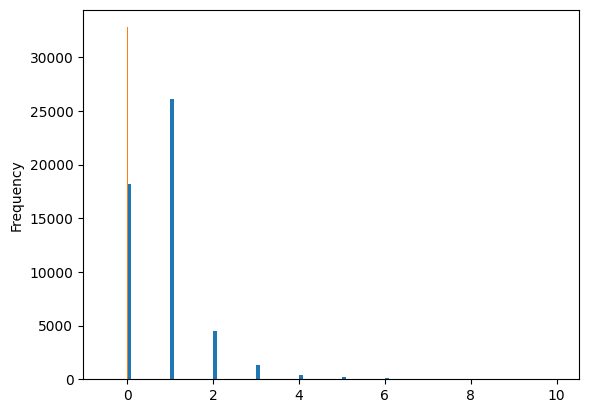

In [136]:
# Load
uniref_df = pd.read_csv(UNIREF_PATH, sep='\t') 
display(uniref_df.head(5))
display(uniref_df.shape)

# Take only even rows (problem with file formatting)
uniref_df = uniref_df.iloc[::2, :] 
display(uniref_df.head(5))
display(uniref_df.shape)

# Remove proteins that are not human
# It might contain additional info like "P12345 (Protein name)" not just IDs
uniref_df["Human Cluster members"] = uniref_df["Cluster members"].apply(
    lambda x: ";".join([
        member.strip() for member in str(x).split(";") 
        if member.strip().split()[0] in all_human_proteins  # Get first token (the ID)
    ]) if pd.notna(x) else ""
)
uniref_df["Human Size"] = uniref_df["Human Cluster members"].apply(
    lambda x: len(x.split(";")) if x else 0
)
display(uniref_df.head(5))
display(uniref_df.shape)

uniref_df["Human Size"].plot(kind="hist", bins=100)

# filter out clusters with 0 freq
uniref_df = uniref_df[uniref_df["Human Size"] > 0]
display(uniref_df.head(5))
display(uniref_df.shape)

# get only clusters with at òeat one paostve protein
uniref_df["Human Positive Cluster members"] = uniref_df["Human Cluster members"].apply(
    lambda x: ";".join([
        member.strip() for member in str(x).split(";") 
        if member.strip().split()[0] in positive_genes  # Get first token (the ID)
    ]) if pd.notna(x) else ""
)
uniref_df["Human Positive Size"] = uniref_df["Human Positive Cluster members"].apply(
    lambda x: len(x.split(";")) if x else 0
)
display(uniref_df.head(5))
display(uniref_df.shape)

uniref_df["Human Positive Size"].plot(kind="hist", bins=100)

# filter out clusters with 0 freq
uniref_df = uniref_df[uniref_df["Human Positive Size"] > 0]
display(uniref_df.head(5))
display(uniref_df.shape)


## Prob being sampled

Necessary for later